# Cryptocurrency Investments Trend and Decision Modeling

# Problem Statement

What opportunities exist as an individual investor to achieve a total return of at least 5% on all short-term cryptocurrency investments held less than 30 days by utilizing technical analysis, blockchain and social media metrics for price predictions?

# Context

Cryptocurrency coins are digital assets designed to work as a medium of exchange where ownership records are transactions are stored in a blockchain ledger using strong cryptography.  Cryptocurrencies typically use decentralized control as opposed to centralized digital currency and central banking systems.  Bitcoin was the first decentralized cryptocurrency formed in 2009 and per coinlore.com there are 5976 active coins trading today.

I was first introduced to cryptocurrencies by a former co-worker in 2017.  If I would have purchased 1 bitcoin in January 2017 for approximately $1000 it would be worth 36K as of today.  Honestly, I did not take it very serious at that time and I still prefer not to invest my life savings in cryptocurrencies.  However, I’m optimistic decentralized currencies have a future in our world so I’m going to use short-term profits to gain in USD but hold some coins for long term benefits.


# 3 Preprocessing<a id='3_preprocessing'></a>

In [1]:
# Import external libraries
import os
import sys
import json
import time
import math
from datetime import datetime
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Ignore warnings for clean output in notebook
import warnings
warnings.filterwarnings('ignore')

In [47]:
# Import local libraries
sys.path.append('..') # Add parent folder for local library imports

# Feature creation functions
from src.features.make_features import *
# Helper functions
from src.utils.helpers import *
# Visualization functions
from src.visuals.make_plots import *

# Load the "autoreload" extension so that code can change
%load_ext autoreload
#%reload_ext autoreload

# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 3.1 Load Data

In [3]:
# Directory references
data_interim_dir = r'..\data\interim'
data_final_dir = r'..\data\final'
model_save_dir = r'..\models'

In [4]:
# Read in Bitcoin data from interim data directory
btc = pd.read_csv(os.path.join(data_interim_dir, 'btc.csv'), parse_dates=['date'])
btc = btc.set_index('date')
btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 718 entries, 2019-08-20 to 2021-08-06
Data columns (total 65 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   asset_id                 718 non-null    int64  
 1   time                     718 non-null    int64  
 2   open                     718 non-null    float64
 3   close                    718 non-null    float64
 4   high                     718 non-null    float64
 5   low                      718 non-null    float64
 6   volume                   718 non-null    float64
 7   market_cap               696 non-null    float64
 8   url_shares               710 non-null    float64
 9   unique_url_shares        710 non-null    float64
 10  tweets                   710 non-null    float64
 11  tweet_spam               710 non-null    float64
 12  tweet_followers          698 non-null    float64
 13  tweet_quotes             698 non-null    float64
 14  tweet_r

In [5]:
# Read in Dogecoin data from interim data directory
doge = pd.read_csv(os.path.join(data_interim_dir, 'doge.csv'), parse_dates=['date'])
doge = doge.set_index('date')
# Add in Bitcoin close price
doge['close_btc'] = btc['close']
doge.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 718 entries, 2019-08-20 to 2021-08-06
Data columns (total 66 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   asset_id                 718 non-null    int64  
 1   time                     718 non-null    int64  
 2   open                     718 non-null    float64
 3   close                    718 non-null    float64
 4   high                     718 non-null    float64
 5   low                      718 non-null    float64
 6   volume                   718 non-null    float64
 7   market_cap               696 non-null    float64
 8   url_shares               704 non-null    float64
 9   unique_url_shares        704 non-null    float64
 10  tweets                   710 non-null    float64
 11  tweet_spam               710 non-null    float64
 12  tweet_followers          698 non-null    float64
 13  tweet_quotes             698 non-null    float64
 14  tweet_r

# 3.2 Feature Engineering

###### Bitcoin

In [6]:
# Add technical anaysis single period metrics
btc = create_single_tp_metrics(btc, 14)
# Add technical analysis multi-period metrics
btc = create_multi_tp_metrics(btc, 12, 26, 9)
# Custom social transformations
custom_transform = [(['tweets', 'tweet_followers', 'tweet_sentiment_impact_net'], 'mean', 20),
                    (['news', 'volatility', 'social_volume_global'], 'mean', 14),
                    (['tweet_sentiment1', 'tweet_sentiment_impact_bearish'], 'stdev', 7),
                    (['market_dominance'], 'stdev', 14),
                   (['market_cap_global'], 'pct_change', 20)
                   ]
# Add social metrics
btc = create_social_metrics(btc, custom_transform)

# Save data to final data directory
btc.to_csv(os.path.join(data_final_dir, 'btc.csv'))

###### Dogecoin

In [7]:
# Add technical anaysis single period metrics
doge = create_single_tp_metrics(doge, 14)
# Add technical analysis multi-period metrics
doge = create_multi_tp_metrics(doge, 12, 26, 9)
# Custom social transformations
custom_transform = [(['tweets', 'tweet_followers', 'tweet_sentiment_impact_net'], 'mean', 20),
                    (['news', 'volatility', 'social_volume_global'], 'mean', 14),
                    (['tweet_sentiment1', 'tweet_sentiment_impact_bearish'], 'stdev', 7),
                    (['market_dominance'], 'stdev', 14),
                   (['market_cap_global'], 'pct_change', 20)
                   ]
# Add social metrics
doge = create_social_metrics(doge, custom_transform)

# Save data to final data directory
doge.to_csv(os.path.join(data_final_dir, 'doge.csv'))

# 3.3 Preprocessing

In [8]:
# Define the number timesteps that will be used for the validation and test datasets based on the prediction sequence_length
target_col = 'close'
target_offset = 1
input_len = 49
total_len = input_len + target_offset
prediction_len = 7
test_periods = prediction_len * 10 + total_len

### 3.3.1 Normalization Methods

In this section I will create functions to perform preprocessing on the dataset and split into train, validation and test sets.  The preprocessing techniques that I will evaluate are:

1. Min-Max normalization (globally across entire dataset)
2. Standardization by removing the mean and scaling to unit variance (globally and across a defined window)
3. % Change normalization (globally and across a defined window)

Let's first visualize the distribution of the output data for the one dimensional dataset for each preprocessing methods

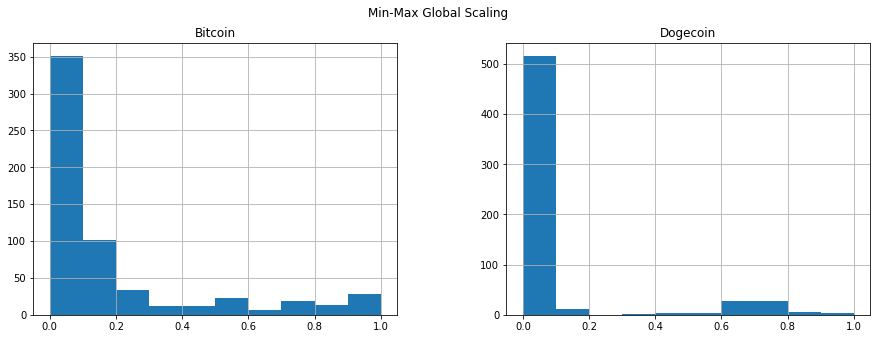

In [9]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()

cols = [target_col]
btc_data, btc_train_scaled_mm, btc_test_scaled_mm, btc_scaler_mm = data_preprocessing_scaling(minmax_scaler, btc, 
                                                                                     cols, test_periods)
doge_data, doge_train_scaled_mm, doge_test_scaled_mm, doge_scaler_mm = data_preprocessing_scaling(minmax_scaler, doge, 
                                                                                         cols, test_periods)

normalization_hist_plot((btc_train_scaled_mm, 'Bitcoin'), 
                        (doge_train_scaled_mm, 'Dogecoin'), 'Min-Max Global Scaling')

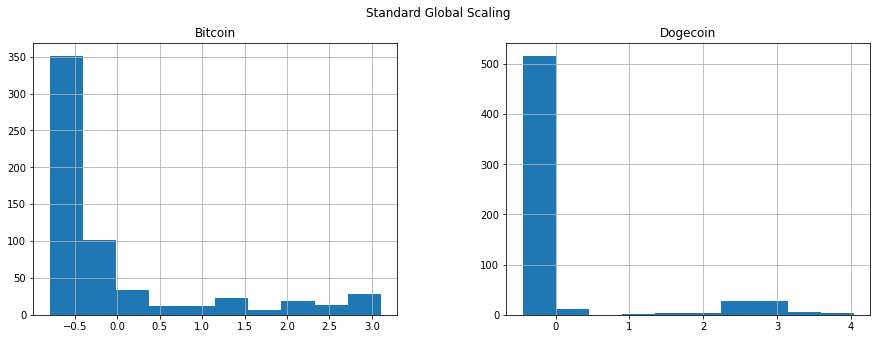

In [10]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()

btc_data, btc_train_scaled_sg, btc_test_scaled_sg, btc_scaler_sg = data_preprocessing_standardize(standard_scaler, btc, cols,
                                                                                         test_periods, -1)

doge_data, doge_train_scaled_sg, doge_test_scaled_sg, doge_scaler_sg = data_preprocessing_standardize(standard_scaler, doge, cols,
                                                                                         test_periods, -1)

normalization_hist_plot((btc_train_scaled_sg, 'Bitcoin'), 
                        (doge_train_scaled_sg, 'Dogecoin'), 'Standard Global Scaling')

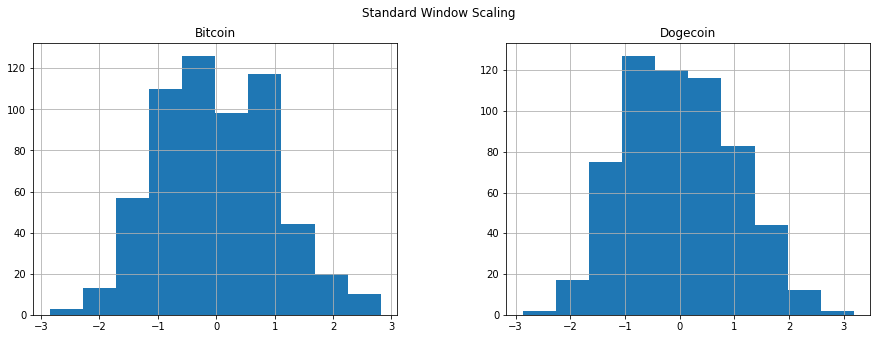

In [11]:
btc_data, btc_train_scaled_sw, btc_test_scaled_sw, btc_scaler_sw = data_preprocessing_standardize(standard_scaler, btc, cols,
                                                                                         test_periods, total_len)

doge_data, doge_train_scaled_sw, doge_test_scaled_sw, doge_scaler_sw = data_preprocessing_standardize(standard_scaler, doge, cols,
                                                                                         test_periods, total_len)

normalization_hist_plot((btc_train_scaled_sw, 'Bitcoin'), 
                        (doge_train_scaled_sw, 'Dogecoin'), 'Standard Window Scaling')

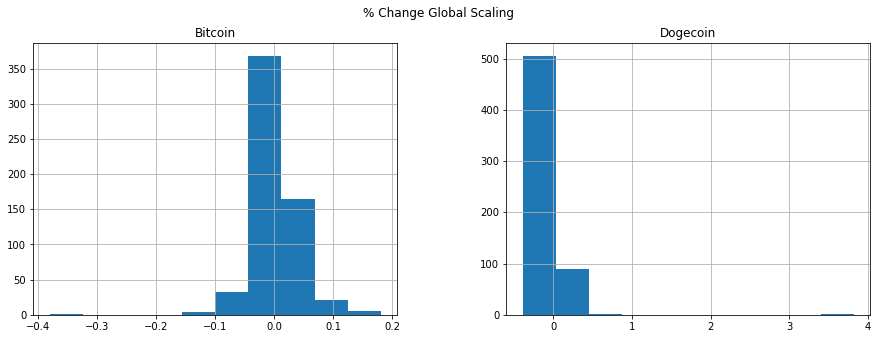

In [12]:
btc_data, btc_train_scaled_pg, btc_test_scaled_pg = data_preprocessing_pct_change(btc, cols, test_periods, -1)

doge_data, doge_train_scaled_pg, doge_test_scaled_pg = data_preprocessing_pct_change(doge, cols, test_periods, -1)

normalization_hist_plot((btc_train_scaled_pg, 'Bitcoin'), 
                        (doge_train_scaled_pg, 'Dogecoin'), '% Change Global Scaling')

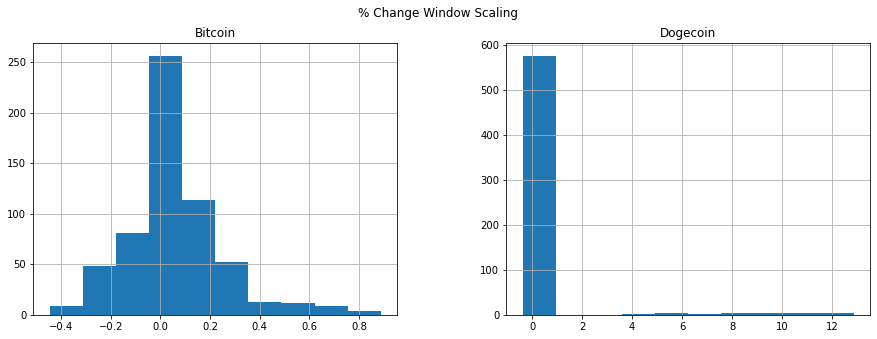

In [13]:
btc_data, btc_train_scaled_pw, btc_test_scaled_pw = data_preprocessing_pct_change(btc, cols, test_periods, total_len)

doge_data, doge_train_scaled_pw, doge_test_scaled_pw = data_preprocessing_pct_change(doge, cols, test_periods, total_len)

normalization_hist_plot((btc_train_scaled_pw, 'Bitcoin'), 
                        (doge_train_scaled_pw, 'Dogecoin'), '% Change Window Scaling')

Standard window scaling normalizes the data the best for both coins.  % Change window scaling normalizes the data very well for Bitcoin but since Dogecoin did not really have large changes in price until 2021 this scaling method is not as effective for Dogecoin.

# 4 Modeling<a id='4_modeling'></a>

## 4.1 Sequence Modeling

The first modeling task for this project is to utilize a Long short-term memory (LSTM) recurrent neural network to make sequence predictions for a future sequence of time steps.  In this case I'm focusing on the ending daily `close` price for each coin.  I'm not as concerned with being able to accurately predict the future `close` price but to be able to identify the directional trend.

In the first stage I will create several one dimensional LSTM models for Bitcoin and Dogecoin to determine the most effective normalization method.

The 4 evaluation metrics I will be using are:

1. `mean directional accuracy` - MDA utilizes the change in value (positive or negative) and averages if the predictions had the same directional change.  Higher is better.
2. `mean absolute error` - MAE averages the absolute value of the prediction error.  I will use this as the loss metric in the model.  Lower is better.
3. `mean absolute scaled error` - MASE uses MAE but scales the result by dividing by the MAE of actual data and a shifted forward naive forecast.  This metric will be scale invariant and allow me to compare the normalization methods across models.  Lower is better.
3. `kendalltau` - Kendall's tau is a correlation measure of the correspondence between 2 arrays.  It is a non-parametric test that determines if the 2 arrays have a monotonic relationship.  I will be averaging the number of sequences in the test data that are statistically significant.  Higher is better for the tau statistic as well as the average tau statistically significant.

### 4.1.1 One Dimensional LSTM Model

##### Bitcoin

In [14]:
# Load LSTM model configuration params
lstm_config = json.load(open('lstm_config.json', 'r'))
lstm_config

{'model': {'loss': 'mae',
  'optimizer': 'adam',
  'layers': [{'type': 'lstm', 'neurons': 100, 'return_seq': True},
   {'type': 'dropout', 'rate': 0.2},
   {'type': 'lstm', 'neurons': 100, 'return_seq': True},
   {'type': 'lstm', 'neurons': 100, 'return_seq': False},
   {'type': 'dropout', 'rate': 0.2},
   {'type': 'dense', 'neurons': 1, 'activation': 'linear'}]}}

In [15]:
btc_model_save_fname = os.path.join(model_save_dir, 'btc_lstm.h5')
# Create LSTM model training configuration params for Bitcoin
btc_train_config = dict(epochs=40,
                        batch_size=32,
                        validation_split=0.15,
                        verbose=1,
                        save_fname=btc_model_save_fname
                       )
btc_train_config

{'epochs': 40,
 'batch_size': 32,
 'validation_split': 0.15,
 'verbose': 1,
 'save_fname': '..\\models\\btc_lstm.h5'}

#### 4.1.1.1 MinMax Scaling Global

In [16]:
btc_train_X, btc_train_y = create_timeseries_data(btc_train_scaled_mm, target_col, input_len)
btc_test_X, btc_test_y = create_timeseries_data(btc_test_scaled_mm, target_col, input_len)

print(btc_train_X.shape)
print(btc_train_y.shape)

(549, 49, 1)
(549,)


In [17]:
# The input_timesteps and dim will vary depending on the data so add this to the configs based on the data
btc_model_config = update_model_input_dim(lstm_config, btc_train_X.shape)
btc_model_config

{'model': {'loss': 'mae',
  'optimizer': 'adam',
  'layers': [{'type': 'lstm',
    'neurons': 100,
    'return_seq': True,
    'input_timesteps': 49,
    'input_dim': 1},
   {'type': 'dropout', 'rate': 0.2},
   {'type': 'lstm', 'neurons': 100, 'return_seq': True},
   {'type': 'lstm', 'neurons': 100, 'return_seq': False},
   {'type': 'dropout', 'rate': 0.2},
   {'type': 'dense', 'neurons': 1, 'activation': 'linear'}]}}

In [18]:
from src.models.rnn_model import Model

# Instantiate model class
btc_lstm_model = Model()

# Build model
btc_lstm_model.build_model(btc_model_config)

btc_lstm_model.train(btc_train_X, btc_train_y, btc_train_config)

Epoch 1/40
15/15 [==============================] - 7s 182ms/step - loss: 0.0481 - val_loss: 0.1022
Epoch 2/40
15/15 [==============================] - 1s 95ms/step - loss: 0.0224 - val_loss: 0.2353
Epoch 3/40
15/15 [==============================] - 1s 75ms/step - loss: 0.0164 - val_loss: 0.3875


In [19]:
# Define variables to evaluate prediction sequences
seq_metric = 'kendalltau'
alpha = 0.05

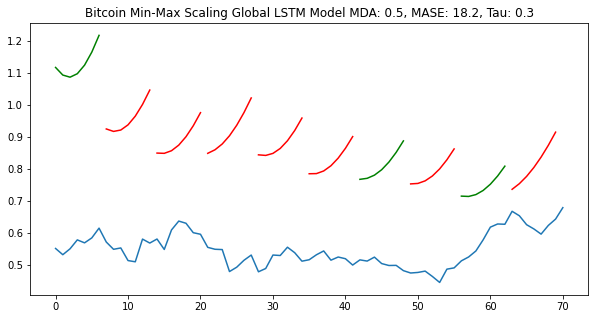

In [20]:
btc_predictions, btc_seq_metrics = evaluate_model(btc_lstm_model, btc_test_X, btc_test_y, total_len, prediction_len)

btc_base_mm_mda = mean_metric_results(btc_seq_metrics, 'mda')
btc_base_mm_mase = mean_metric_results(btc_seq_metrics, 'mase')
btc_base_mm_tau = mean_tau_stat_sig(btc_seq_metrics, alpha)

title = 'Bitcoin Min-Max Scaling Global LSTM Model MDA: {:.3}, MASE: {:.3}, Tau: {:.3}'.format(btc_base_mm_mda, 
                                                                                        btc_base_mm_mase,
                                                                                        btc_base_mm_tau)
plot_results_multiple(btc_predictions, btc_test_y, prediction_len, seq_metric, alpha, title)

Performance is generally very poor using Min-Max scaling with the predictions being completely off the mark but the trend detection is correct on several sequences.

#### 4.1.1.2 Standard Scaler Global

In [21]:
btc_train_X, btc_train_y = create_timeseries_data(btc_train_scaled_sg, target_col, input_len)
btc_test_X, btc_test_y = create_timeseries_data(btc_test_scaled_sg, target_col, input_len)

print(btc_train_X.shape)
print(btc_train_y.shape)

(549, 49, 1)
(549,)


In [22]:
# Instantiate model class
btc_lstm_model = Model()

# Build model
btc_lstm_model.build_model(btc_model_config)

btc_lstm_model.train(btc_train_X, btc_train_y, btc_train_config)

Epoch 1/40
15/15 [==============================] - 6s 162ms/step - loss: 0.1824 - val_loss: 0.6095
Epoch 2/40
15/15 [==============================] - 1s 77ms/step - loss: 0.0852 - val_loss: 0.7548
Epoch 3/40
15/15 [==============================] - 1s 88ms/step - loss: 0.0630 - val_loss: 0.4699
Epoch 4/40
15/15 [==============================] - 1s 85ms/step - loss: 0.0671 - val_loss: 0.6316
Epoch 5/40
15/15 [==============================] - 1s 78ms/step - loss: 0.0590 - val_loss: 0.2850
Epoch 6/40
15/15 [==============================] - 1s 81ms/step - loss: 0.0627 - val_loss: 0.2969
Epoch 7/40
15/15 [==============================] - 1s 79ms/step - loss: 0.0598 - val_loss: 0.2997


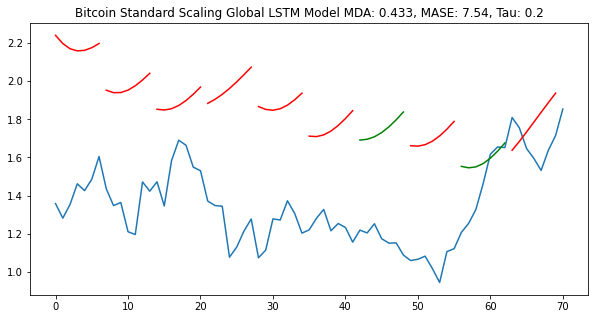

In [23]:
btc_predictions, btc_seq_metrics = evaluate_model(btc_lstm_model, btc_test_X, btc_test_y, total_len, prediction_len)

btc_base_sg_mda = mean_metric_results(btc_seq_metrics, 'mda')
btc_base_sg_mase = mean_metric_results(btc_seq_metrics, 'mase')
btc_base_sg_tau = mean_tau_stat_sig(btc_seq_metrics, alpha)

title = 'Bitcoin Standard Scaling Global LSTM Model MDA: {:.3}, MASE: {:.3}, Tau: {:.3}'.format(btc_base_sg_mda, 
                                                                                        btc_base_sg_mase,
                                                                                        btc_base_sg_tau)
plot_results_multiple(btc_predictions, btc_test_y, prediction_len, seq_metric, alpha, title)

The predictions for standard scaling global are quite similar to Min-Max scaling.

#### 4.1.1.3 Standard Scaler Window

In [24]:
btc_train_X, btc_train_y = create_timeseries_data(btc_train_scaled_sw, target_col, input_len)
btc_test_X, btc_test_y = create_timeseries_data(btc_test_scaled_sw, target_col, input_len)

print(btc_train_X.shape)
print(btc_train_y.shape)

(549, 49, 1)
(549,)


In [25]:
# Instantiate model class
btc_lstm_model = Model()

# Build model
btc_lstm_model.build_model(btc_model_config)

btc_lstm_model.train(btc_train_X, btc_train_y, btc_train_config)

Epoch 1/40
15/15 [==============================] - 6s 141ms/step - loss: 0.7427 - val_loss: 0.7590
Epoch 2/40
15/15 [==============================] - 1s 81ms/step - loss: 0.6752 - val_loss: 0.7035
Epoch 3/40
15/15 [==============================] - 1s 79ms/step - loss: 0.6125 - val_loss: 0.6291
Epoch 4/40
15/15 [==============================] - 1s 82ms/step - loss: 0.5663 - val_loss: 0.5340
Epoch 5/40
15/15 [==============================] - 1s 80ms/step - loss: 0.5353 - val_loss: 0.5082
Epoch 6/40
15/15 [==============================] - 1s 83ms/step - loss: 0.5038 - val_loss: 0.4747
Epoch 7/40
15/15 [==============================] - 1s 79ms/step - loss: 0.4605 - val_loss: 0.4507
Epoch 8/40
15/15 [==============================] - 1s 81ms/step - loss: 0.4342 - val_loss: 0.4316
Epoch 9/40
15/15 [==============================] - 1s 90ms/step - loss: 0.3984 - val_loss: 0.3703
Epoch 10/40
15/15 [==============================] - 1s 84ms/step - loss: 0.4067 - val_loss: 0.3941
Epoch 11

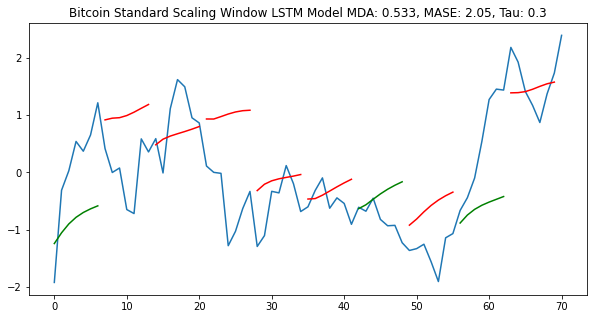

In [26]:
btc_predictions, btc_seq_metrics = evaluate_model(btc_lstm_model, btc_test_X, btc_test_y, total_len, prediction_len)

btc_base_sw_mda = mean_metric_results(btc_seq_metrics, 'mda')
btc_base_sw_mase = mean_metric_results(btc_seq_metrics, 'mase')
btc_base_sw_tau = mean_tau_stat_sig(btc_seq_metrics, alpha)

title = 'Bitcoin Standard Scaling Window LSTM Model MDA: {:.3}, MASE: {:.3}, Tau: {:.3}'.format(btc_base_sw_mda, 
                                                                                        btc_base_sw_mase,
                                                                                        btc_base_sw_tau)
plot_results_multiple(btc_predictions, btc_test_y, prediction_len, seq_metric, alpha, title)

Standard scaling across a window generally performs much better then the prior 2 methods.  Although the tau statistic is only statistically signifiant for some sequences, looking at the predictions these are much more accurate than prior scaling methods.  Window standard scalling will be explored further with Dogecoin.

#### 4.1.1.4 Percentage Change Global

In [27]:
btc_train_X, btc_train_y = create_timeseries_data(btc_train_scaled_pg, target_col, input_len)
btc_test_X, btc_test_y = create_timeseries_data(btc_test_scaled_pg, target_col, input_len)

print(btc_train_X.shape)
print(btc_train_y.shape)

(548, 49, 1)
(548,)


In [28]:
# Instantiate model class
btc_lstm_model = Model()

# Build model
btc_lstm_model.build_model(btc_model_config)

btc_lstm_model.train(btc_train_X, btc_train_y, btc_train_config)

Epoch 1/40
15/15 [==============================] - 6s 156ms/step - loss: 0.0262 - val_loss: 0.0318
Epoch 2/40
15/15 [==============================] - 1s 82ms/step - loss: 0.0249 - val_loss: 0.0302
Epoch 3/40
15/15 [==============================] - 1s 74ms/step - loss: 0.0252 - val_loss: 0.0304
Epoch 4/40
15/15 [==============================] - 1s 73ms/step - loss: 0.0251 - val_loss: 0.0299
Epoch 5/40
15/15 [==============================] - 1s 74ms/step - loss: 0.0246 - val_loss: 0.0306
Epoch 6/40
15/15 [==============================] - 1s 102ms/step - loss: 0.0251 - val_loss: 0.0311


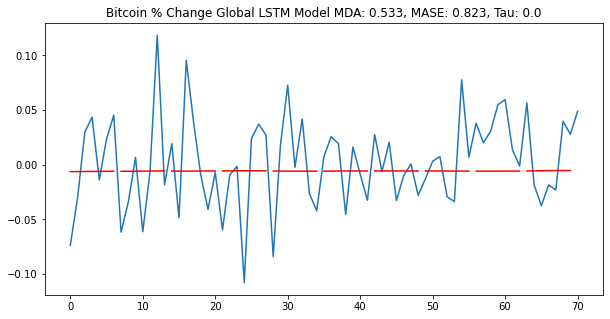

In [29]:
btc_predictions, btc_seq_metrics = evaluate_model(btc_lstm_model, btc_test_X, btc_test_y, total_len, prediction_len)

btc_base_pg_mda = mean_metric_results(btc_seq_metrics, 'mda')
btc_base_pg_mase = mean_metric_results(btc_seq_metrics, 'mase')
btc_base_pg_tau = mean_tau_stat_sig(btc_seq_metrics, alpha)

title = 'Bitcoin % Change Global LSTM Model MDA: {:.3}, MASE: {:.3}, Tau: {:.3}'.format(btc_base_pg_mda, 
                                                                                        btc_base_pg_mase,
                                                                                        btc_base_pg_tau)
plot_results_multiple(btc_predictions, btc_test_y, prediction_len, seq_metric, alpha, title)

% Change globally is clearly the worst performing.  The sequence predictions are almost completely flat.  This also highlights the weakness with the MDA and MASE metrics.

#### 4.1.1.5 Percentage Change Window

In [30]:
btc_train_X, btc_train_y = create_timeseries_data(btc_train_scaled_pw, target_col, input_len)
btc_test_X, btc_test_y = create_timeseries_data(btc_test_scaled_pw, target_col, input_len)

print(btc_train_X.shape)
print(btc_train_y.shape)

(549, 49, 1)
(549,)


In [31]:
# Instantiate model class
btc_lstm_model = Model()

# Build model
btc_lstm_model.build_model(btc_model_config)

btc_lstm_model.train(btc_train_X, btc_train_y, btc_train_config)

Epoch 1/40
15/15 [==============================] - 7s 207ms/step - loss: 0.0991 - val_loss: 0.1678
Epoch 2/40
15/15 [==============================] - 2s 122ms/step - loss: 0.0899 - val_loss: 0.1328
Epoch 3/40
15/15 [==============================] - 2s 133ms/step - loss: 0.0805 - val_loss: 0.1235
Epoch 4/40
15/15 [==============================] - 2s 149ms/step - loss: 0.0702 - val_loss: 0.1106
Epoch 5/40
15/15 [==============================] - 2s 129ms/step - loss: 0.0672 - val_loss: 0.1042
Epoch 6/40
15/15 [==============================] - 2s 127ms/step - loss: 0.0644 - val_loss: 0.0962
Epoch 7/40
15/15 [==============================] - 2s 130ms/step - loss: 0.0628 - val_loss: 0.0908
Epoch 8/40
15/15 [==============================] - 2s 129ms/step - loss: 0.0624 - val_loss: 0.0855
Epoch 9/40
15/15 [==============================] - 2s 134ms/step - loss: 0.0559 - val_loss: 0.0804
Epoch 10/40
15/15 [==============================] - 2s 133ms/step - loss: 0.0558 - val_loss: 0.0767

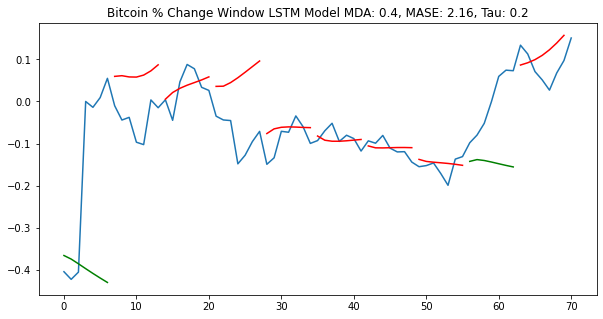

In [32]:
btc_predictions, btc_seq_metrics = evaluate_model(btc_lstm_model, btc_test_X, btc_test_y, total_len, prediction_len)

btc_base_pw_mda = mean_metric_results(btc_seq_metrics, 'mda')
btc_base_pw_mase = mean_metric_results(btc_seq_metrics, 'mase')
btc_base_pw_tau = mean_tau_stat_sig(btc_seq_metrics, alpha)

title = 'Bitcoin % Change Window LSTM Model MDA: {:.3}, MASE: {:.3}, Tau: {:.3}'.format(btc_base_pw_mda, 
                                                                                        btc_base_pw_mase,
                                                                                        btc_base_pw_tau)
plot_results_multiple(btc_predictions, btc_test_y, prediction_len, seq_metric, alpha, title)

Due to stochastic nature of a rnn model training, the results can vary for each run so next I will train a model for Standard and % Change window scalling multiple times and then average the evaluation metrics.

##### Training Runs

In [33]:
training_runs = 10
btc_sw_results = []
btc_train_X, btc_train_y = create_timeseries_data(btc_train_scaled_sw, target_col, input_len)
btc_test_X, btc_test_y = create_timeseries_data(btc_test_scaled_sw, target_col, input_len)
# Turn off verbose since training multiple models
btc_train_config['verbose'] = 0
for i in range(training_runs):
    # Instantiate model class
    btc_lstm_model = Model()
    # Build model
    btc_lstm_model.build_model(btc_model_config)
    print('Model Training started for instance {}'.format(i+1))
    # Train model
    btc_lstm_model.train(btc_train_X, btc_train_y, btc_train_config)
    # Evaluate model
    btc_predictions, btc_seq_metrics = evaluate_model(btc_lstm_model, btc_test_X, btc_test_y, total_len, prediction_len)
    # Append results
    btc_sw_results.append(btc_seq_metrics)

Model Training started for instance 1
Model Training started for instance 2
Model Training started for instance 3
Model Training started for instance 4
Model Training started for instance 5
Model Training started for instance 6
Model Training started for instance 7
Model Training started for instance 8
Model Training started for instance 9
Model Training started for instance 10


In [37]:
btc_base_sw_mda = mean_metric_seq_results(btc_sw_results, 'mda')
btc_base_sw_mase = mean_metric_seq_results(btc_sw_results, 'mase')
btc_base_sw_tau = mean_tau_seq_stat_sig(btc_sw_results, alpha)
print('Bitcoin Standard Scaling Window Baseline Metrics MDA: {:.3}, MASE: {:.3}, Tau: {:.3}.'.\
format(btc_base_sw_mda, btc_base_sw_mase, btc_base_sw_tau))

Bitcoin Standard Scaling Window Baseline Metrics MDA: 0.538, MASE: 2.03, Tau: 0.27.


In [38]:
btc_pw_results = []
btc_train_X, btc_train_y = create_timeseries_data(btc_train_scaled_pw, target_col, input_len)
btc_test_X, btc_test_y = create_timeseries_data(btc_test_scaled_pw, target_col, input_len)
# Turn off verbose since training multiple models
btc_train_config['verbose'] = 0
for i in range(training_runs):
    # Instantiate model class
    btc_lstm_model = Model()
    # Build model
    btc_lstm_model.build_model(btc_model_config)
    print('Model Training started for instance {}'.format(i+1))
    # Train model
    btc_lstm_model.train(btc_train_X, btc_train_y, btc_train_config)
    # Evaluate model
    btc_predictions, btc_seq_metrics = evaluate_model(btc_lstm_model, btc_test_X, btc_test_y, total_len, prediction_len)
    # Append results
    btc_pw_results.append(btc_seq_metrics)

Model Training started for instance 1
Model Training started for instance 2
Model Training started for instance 3
Model Training started for instance 4
Model Training started for instance 5
Model Training started for instance 6
Model Training started for instance 7
Model Training started for instance 8
Model Training started for instance 9
Model Training started for instance 10


In [40]:
btc_base_pw_mda = mean_metric_seq_results(btc_pw_results, 'mda')
btc_base_pw_mase = mean_metric_seq_results(btc_pw_results, 'mase')
btc_base_pw_tau = mean_tau_seq_stat_sig(btc_pw_results, alpha)
print('Bitcoin % Change Scaling Window Baseline Metrics MDA: {:.3}, MASE: {:.3}, Tau: {:.3}.'.\
format(btc_base_pw_mda, btc_base_pw_mase, btc_base_pw_tau))

Bitcoin % Change Scaling Window Baseline Metrics MDA: 0.533, MASE: 2.36, Tau: 0.28.


##### Dogecoin

This will be the first time creating a model for Dogecoin so need to create the datasets and configs.

In [41]:
# Create train/test data for doge
doge_train_X, doge_train_y = create_timeseries_data(doge_train_scaled_sw, target_col, input_len)
doge_test_X, doge_test_y = create_timeseries_data(doge_test_scaled_sw, target_col, input_len)

print(doge_train_X.shape)
print(doge_train_y.shape)

(549, 49, 1)
(549,)


In [42]:
# The input_timesteps and dim will vary depending on the data so add this to the configs based on the data
doge_model_config = update_model_input_dim(lstm_config, doge_train_X.shape)
doge_model_config

{'model': {'loss': 'mae',
  'optimizer': 'adam',
  'layers': [{'type': 'lstm',
    'neurons': 100,
    'return_seq': True,
    'input_timesteps': 49,
    'input_dim': 1},
   {'type': 'dropout', 'rate': 0.2},
   {'type': 'lstm', 'neurons': 100, 'return_seq': True},
   {'type': 'lstm', 'neurons': 100, 'return_seq': False},
   {'type': 'dropout', 'rate': 0.2},
   {'type': 'dense', 'neurons': 1, 'activation': 'linear'}]}}

In [43]:
doge_model_save_fname = os.path.join(model_save_dir, 'doge_lstm.h5')
# Create LSTM model training configuration params for Dogecoin
doge_train_config = dict(epochs=40,
                        batch_size=32,
                        validation_split=0.15,
                        verbose=0,
                        save_fname=doge_model_save_fname
                       )
doge_train_config

{'epochs': 40,
 'batch_size': 32,
 'validation_split': 0.15,
 'verbose': 0,
 'save_fname': '..\\models\\doge_lstm.h5'}

In [44]:
doge_sw_results = []

for i in range(training_runs):
    # Instantiate model class
    doge_lstm_model = Model()
    # Build model
    doge_lstm_model.build_model(doge_model_config)
    print('Model Training started for instance {}'.format(i+1))
    # Train model
    doge_lstm_model.train(doge_train_X, doge_train_y, doge_train_config)
    # Evaluate model
    doge_predictions, doge_seq_metrics = evaluate_model(doge_lstm_model, doge_test_X, doge_test_y, total_len, prediction_len)
    # Append results
    doge_sw_results.append(doge_seq_metrics)

Model Training started for instance 1
Model Training started for instance 2
Model Training started for instance 3
Model Training started for instance 4
Model Training started for instance 5
Model Training started for instance 6
Model Training started for instance 7
Model Training started for instance 8
Model Training started for instance 9
Model Training started for instance 10


In [49]:
doge_base_sw_mda = mean_metric_seq_results(doge_sw_results, 'mda')
doge_base_sw_mase = mean_metric_seq_results(doge_sw_results, 'mase')
doge_base_sw_tau = mean_tau_seq_stat_sig(doge_sw_results, alpha)
print('Dogecoin Standard Scaling Window Baseline Metrics MDA: {:.3}, MASE: {:.3}, Tau: {:.3}.'.\
format(doge_base_sw_mda, doge_base_sw_mase, doge_base_sw_tau))

Dogecoin Standard Scaling Window Baseline Metrics MDA: 0.512, MASE: 4.66, Tau: 0.36.


In [50]:
doge_pw_results = []

# Create train/test data for doge
doge_train_X, doge_train_y = create_timeseries_data(doge_train_scaled_pw, target_col, input_len)
doge_test_X, doge_test_y = create_timeseries_data(doge_test_scaled_pw, target_col, input_len)

for i in range(training_runs):
    # Instantiate model class
    doge_lstm_model = Model()
    # Build model
    doge_lstm_model.build_model(doge_model_config)
    print('Model Training started for instance {}'.format(i+1))
    # Train model
    doge_lstm_model.train(doge_train_X, doge_train_y, doge_train_config)
    # Evaluate model
    doge_predictions, doge_seq_metrics = evaluate_model(doge_lstm_model, doge_test_X, doge_test_y, total_len, prediction_len)
    # Append results
    doge_pw_results.append(doge_seq_metrics)

Model Training started for instance 1
Model Training started for instance 2
Model Training started for instance 3
Model Training started for instance 4
Model Training started for instance 5
Model Training started for instance 6
Model Training started for instance 7
Model Training started for instance 8
Model Training started for instance 9
Model Training started for instance 10


In [51]:
doge_base_pw_mda = mean_metric_seq_results(doge_pw_results, 'mda')
doge_base_pw_mase = mean_metric_seq_results(doge_pw_results, 'mase')
doge_base_pw_tau = mean_tau_seq_stat_sig(doge_pw_results, alpha)
print('Dogecoin % Change Scaling Window Baseline Metrics MDA: {:.3}, MASE: {:.3}, Tau: {:.3}.'.\
format(doge_base_pw_mda, doge_base_pw_mase, doge_base_pw_tau))

Dogecoin % Change Scaling Window Baseline Metrics MDA: 0.522, MASE: 8.01, Tau: 0.31.


Standard scaling window is clearly the better method of Dogecoin.  This was also observed earlier in the distribution of the scaled data.  For Bitcoin, the difference between the 2 methods is pretty minimal and varies depending on the random nature of the model training process.  I will utilize Standard scaling windows moving forward.

### 4.1.2 Multi-Dimensional LSTM Model

I have over 100 features so instead of using all in a multi-dimensional model I will train a model with each incrementally added to `close` and then evaluate if the feature improves from the baseline one-dimensional model.  I will then select the features for each Bitcoin and Dogecoin model.

In [53]:
btc_search_cols = list(btc.drop(['asset_id', 'time', 'open', 'close', 'name', 'symbol', 'price_btc',
                             'close_end_1d', 'close_percent_change_1d', 'close_end_7d', 'close_min_7d', 
                             'close_max_7d', 'close_loss_7d', 'close_gain_7d', 'close_change_7d', 
                             'close_percent_change_7d', 'decision','color','angle', 'intercept']
                            , axis=1).columns)
btc_search_cols

['high',
 'low',
 'volume',
 'market_cap',
 'url_shares',
 'unique_url_shares',
 'tweets',
 'tweet_spam',
 'tweet_followers',
 'tweet_quotes',
 'tweet_retweets',
 'tweet_replies',
 'tweet_favorites',
 'tweet_sentiment1',
 'tweet_sentiment2',
 'tweet_sentiment3',
 'tweet_sentiment4',
 'tweet_sentiment5',
 'tweet_sentiment_impact1',
 'tweet_sentiment_impact2',
 'tweet_sentiment_impact3',
 'tweet_sentiment_impact4',
 'tweet_sentiment_impact5',
 'social_score',
 'average_sentiment',
 'sentiment_relative',
 'news',
 'price_score',
 'social_impact_score',
 'correlation_rank',
 'galaxy_score',
 'volatility',
 'alt_rank',
 'alt_rank_30d',
 'market_cap_rank',
 'percent_change_24h_rank',
 'volume_24h_rank',
 'social_volume_24h_rank',
 'social_score_24h_rank',
 'medium',
 'youtube',
 'social_contributors',
 'social_volume',
 'social_volume_global',
 'percent_change_24h',
 'market_cap_global',
 'market_dominance',
 'adx',
 'cci',
 'cmo',
 'dx',
 'roc',
 'rsi',
 'willr',
 'atr',
 'corr',
 'linreg',

In [56]:
btc_search_results = {}

for col in btc_search_cols:
    cols = [*[target_col], *[col]]
    # Scale data based on new cols list
    btc_data, btc_train_scaled, btc_test_scaled, btc_scaler = data_preprocessing_standardize(standard_scaler, btc, cols,
                                                                                         test_periods, total_len)
    # Create train/test datasets
    btc_train_X, btc_train_y = create_timeseries_data(btc_train_scaled, target_col, input_len)
    btc_test_X, btc_test_y = create_timeseries_data(btc_test_scaled, target_col, input_len)
    
    btc_model_config = update_model_input_dim(lstm_config, btc_train_X.shape)
    
    # Set verbose to off since training many models
    btc_train_config['verbose'] = 0
        
    # Instantiate model class
    btc_lstm_model = Model()

    # Build model
    btc_lstm_model.build_model(btc_model_config)

    print('Model Training started for {}'.format(col))
    btc_lstm_model.train(btc_train_X, btc_train_y, btc_train_config)
    
    btc_predictions, btc_seq_metrics = evaluate_model(btc_lstm_model, btc_test_X, btc_test_y, total_len, prediction_len)

    mda = mean_metric_results(btc_seq_metrics, 'mda')
    mase = mean_metric_results(btc_seq_metrics, 'mase')
    tau = mean_tau_stat_sig(btc_seq_metrics, alpha)
    # Save results
    btc_search_results[col] = {'mda': mda, 'mase': mase, 'tau': tau}

Model Training started for high
Model Training started for low
Model Training started for volume
Model Training started for market_cap
Model Training started for url_shares
Model Training started for unique_url_shares
Model Training started for tweets
Model Training started for tweet_spam
Model Training started for tweet_followers
Model Training started for tweet_quotes
Model Training started for tweet_retweets
Model Training started for tweet_replies
Model Training started for tweet_favorites
Model Training started for tweet_sentiment1
Model Training started for tweet_sentiment2
Model Training started for tweet_sentiment3
Model Training started for tweet_sentiment4
Model Training started for tweet_sentiment5
Model Training started for tweet_sentiment_impact1
Model Training started for tweet_sentiment_impact2
Model Training started for tweet_sentiment_impact3
Model Training started for tweet_sentiment_impact4
Model Training started for tweet_sentiment_impact5
Model Training started for

In [81]:
btc_search_results_df = pd.DataFrame(btc_search_results).T

btc_search_results_df[(btc_search_results_df['mda'] > btc_base_sw_mda) |
                     (btc_search_results_df['mase'] < btc_base_sw_mase) |
                      (btc_search_results_df['tau'] > btc_base_sw_tau)
                     ].sort_values(by='mase', ascending=True)

,mda,mase,tau
url_shares,0.516667,1.679318,0.3
volatility_mean,0.516667,1.697191,0.3
social_score,0.483333,1.722989,0.3
market_dominance_stdev,0.700000,1.729009,0.3
social_score_24h_rank,0.700000,1.738831,0.4
...,...,...,...
adx,0.450000,2.492133,0.3
tweet_sentiment_impact_net_mean,0.383333,2.558156,0.4
social_volume_24h_rank,0.500000,2.586472,0.3
social_volume_global_mean,0.500000,2.604846,0.3


In [85]:
btc_search_results_df.sort_values(by='mda', ascending=False)

,mda,mase,tau
social_score_24h_rank,0.700000,1.738831,0.4
market_dominance_stdev,0.700000,1.729009,0.3
tweet_sentiment_impact_bearish,0.650000,1.895168,0.4
social_contributors,0.633333,1.823228,0.3
tsf,0.633333,1.857496,0.4
...,...,...,...
sentiment_relative,0.416667,2.610911,0.2
tweet_sentiment_impact_net_mean,0.383333,2.558156,0.4
bband_relative,0.383333,2.111388,0.2
tweet_replies,0.366667,2.570590,0.1


Epoch 1/40
15/15 [==============================] - 7s 190ms/step - loss: 0.6978 - val_loss: 0.7587
Epoch 2/40
15/15 [==============================] - 2s 129ms/step - loss: 0.5627 - val_loss: 0.7773
Epoch 3/40
15/15 [==============================] - 3s 174ms/step - loss: 0.5306 - val_loss: 0.6431
Epoch 4/40
15/15 [==============================] - 2s 151ms/step - loss: 0.5197 - val_loss: 0.5820
Epoch 5/40
15/15 [==============================] - 3s 168ms/step - loss: 0.4821 - val_loss: 0.6041
Epoch 6/40
15/15 [==============================] - 2s 128ms/step - loss: 0.4659 - val_loss: 0.5538
Epoch 7/40
15/15 [==============================] - 2s 126ms/step - loss: 0.4532 - val_loss: 0.5248
Epoch 8/40
15/15 [==============================] - 2s 147ms/step - loss: 0.4495 - val_loss: 0.5509
Epoch 9/40
15/15 [==============================] - 2s 147ms/step - loss: 0.4346 - val_loss: 0.4965
Epoch 10/40
15/15 [==============================] - 2s 127ms/step - loss: 0.4178 - val_loss: 0.5512

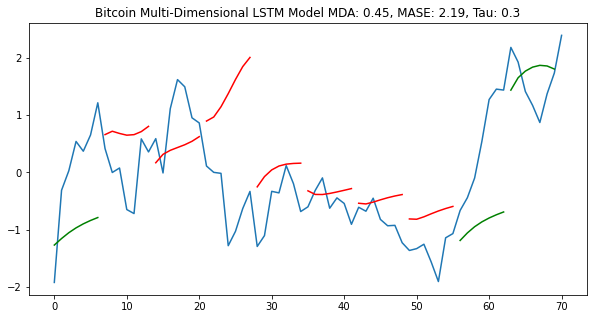

In [88]:
btc_cols = ['tweet_sentiment_impact_bearish']

cols = [*[target_col], * btc_cols]
# Scale data based on new cols list
btc_data, btc_train_scaled, btc_test_scaled, btc_scaler = data_preprocessing_standardize(standard_scaler, btc, cols,
                                                                                     test_periods, total_len)
# Create train/test datasets
btc_train_X, btc_train_y = create_timeseries_data(btc_train_scaled, target_col, input_len)
btc_test_X, btc_test_y = create_timeseries_data(btc_test_scaled, target_col, input_len)

btc_model_config = update_model_input_dim(lstm_config, btc_train_X.shape)

# Set verbose to on
btc_train_config['verbose'] = 1

# Instantiate model class
btc_lstm_model = Model()

# Build model
btc_lstm_model.build_model(btc_model_config)

btc_lstm_model.train(btc_train_X, btc_train_y, btc_train_config)

btc_predictions, btc_seq_metrics = evaluate_model(btc_lstm_model, btc_test_X, btc_test_y, total_len, prediction_len)

btc_mda = mean_metric_results(btc_seq_metrics, 'mda')
btc_mase = mean_metric_results(btc_seq_metrics, 'mase')
btc_tau = mean_tau_stat_sig(btc_seq_metrics, alpha)

title = 'Bitcoin Multi-Dimensional LSTM Model MDA: {:.3}, MASE: {:.3}, Tau: {:.3}'.format(btc_mda, 
                                                                                        btc_mase,
                                                                                        btc_tau)
plot_results_multiple(btc_predictions, btc_test_y, prediction_len, seq_metric, alpha, title)

In [ ]:
# doge_search_results = {}
# for col in search_cols:
#     cols = [*[target_col], *[col]]
#     doge_data, doge_train_scaled, doge_test_scaled, doge_scaler = data_preprocessing_standardize(standard_scaler, doge, cols,
#                                                                                          test_periods, total_len)
#     doge_train_X, doge_train_y = create_timeseries_data(doge_train_scaled, target_col, input_len)
#     doge_test_X, doge_test_y = create_timeseries_data(doge_test_scaled, target_col, input_len)
    
#     doge_model_config = update_model_input_dim(lstm_config, doge_train_X.shape)
    
#     # Set verbose to off since training many models
#     doge_train_config['verbose'] = 0
        
#     # Instantiate model class
#     doge_lstm_model = Model()

#     # Build model
#     doge_lstm_model.build_model(doge_model_config)

#     doge_lstm_model.train(doge_train_X, doge_train_y, doge_train_config)
    
#     doge_predictions, doge_seq_metrics = evaluate_model(doge_lstm_model, doge_test_X, doge_test_y, total_len, prediction_len)

#     doge_search_results[col] = doge_seq_metrics

Epoch 1/40
15/15 [==============================] - 8s 311ms/step - loss: 0.7624 - val_loss: 0.7488
Epoch 2/40
15/15 [==============================] - 2s 140ms/step - loss: 0.7084 - val_loss: 0.7004
Epoch 3/40
15/15 [==============================] - 2s 132ms/step - loss: 0.6656 - val_loss: 0.5946
Epoch 4/40
15/15 [==============================] - 2s 133ms/step - loss: 0.6228 - val_loss: 0.5414
Epoch 5/40
15/15 [==============================] - 2s 129ms/step - loss: 0.5891 - val_loss: 0.4780
Epoch 6/40
15/15 [==============================] - 2s 129ms/step - loss: 0.5448 - val_loss: 0.4651
Epoch 7/40
15/15 [==============================] - 2s 134ms/step - loss: 0.4998 - val_loss: 0.4391
Epoch 8/40
15/15 [==============================] - 2s 130ms/step - loss: 0.4852 - val_loss: 0.4574
Epoch 9/40
15/15 [==============================] - 2s 133ms/step - loss: 0.4751 - val_loss: 0.4354
Epoch 10/40
15/15 [==============================] - 2s 133ms/step - loss: 0.4574 - val_loss: 0.4066

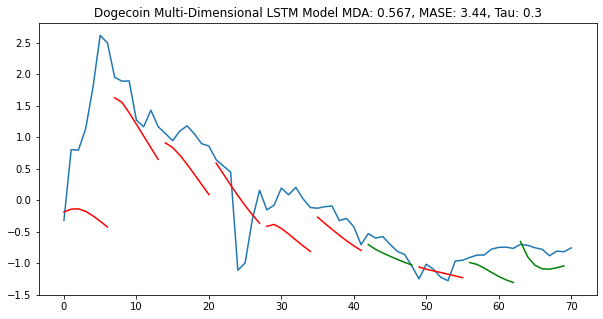

In [89]:
doge_cols = ['close_btc']

cols = [*[target_col], * doge_cols]
# Scale data based on new cols list
doge_data, doge_train_scaled, doge_test_scaled, doge_scaler = data_preprocessing_standardize(standard_scaler, doge, cols,
                                                                                     test_periods, total_len)
# Create train/test datasets
doge_train_X, doge_train_y = create_timeseries_data(doge_train_scaled, target_col, input_len)
doge_test_X, doge_test_y = create_timeseries_data(doge_test_scaled, target_col, input_len)

doge_model_config = update_model_input_dim(lstm_config, doge_train_X.shape)

# Set verbose to on
doge_train_config['verbose'] = 1

# Instantiate model class
doge_lstm_model = Model()

# Build model
doge_lstm_model.build_model(doge_model_config)

doge_lstm_model.train(doge_train_X, doge_train_y, doge_train_config)

doge_predictions, doge_seq_metrics = evaluate_model(doge_lstm_model, doge_test_X, doge_test_y, total_len, prediction_len)

doge_mda = mean_metric_results(doge_seq_metrics, 'mda')
doge_mase = mean_metric_results(doge_seq_metrics, 'mase')
doge_tau = mean_tau_stat_sig(doge_seq_metrics, alpha)

title = 'Dogecoin Multi-Dimensional LSTM Model MDA: {:.3}, MASE: {:.3}, Tau: {:.3}'.format(doge_mda, 
                                                                                        doge_mase,
                                                                                        doge_tau)
plot_results_multiple(doge_predictions, doge_test_y, prediction_len, seq_metric, alpha, title)

In [103]:
doge_test_y[14:21]

array([1.0562931 , 0.94333382, 1.09708239, 1.17907947, 1.05043107,
       0.89528677, 0.858069  ])

In [104]:
doge_predictions[2]

[0.90893376,
 0.8335141,
 0.7127556,
 0.56666315,
 0.4085372,
 0.24714254,
 0.08839409]

In [97]:
mda(doge_test_y[7:14], doge_predictions[1])

TypeError: 'numpy.float64' object is not callable

In [90]:
doge_seq_metrics

{'mda': [0.3333333333333333,
  0.6666666666666666,
  0.6666666666666666,
  0.5,
  0.6666666666666666,
  0.5,
  0.8333333333333334,
  0.5,
  0.16666666666666666,
  0.8333333333333334],
 'mae': [1.6045269,
  0.35688442,
  0.47337642,
  0.44022658,
  0.5869747,
  0.25142792,
  0.15299225,
  0.1406659,
  0.33254346,
  0.2168343],
 'mase': [3.136469,
  1.6275717,
  4.2409935,
  0.8733287,
  3.950186,
  2.1063836,
  1.6386529,
  1.0320994,
  10.850637,
  4.894289],
 'kendalltau': [(-0.6190476190476191, 0.06904761904761905),
  (0.6190476190476191, 0.06904761904761905),
  (0.4285714285714286, 0.2388888888888889),
  (0.4285714285714286, 0.2388888888888889),
  (-0.04761904761904762, 1.0),
  (0.6190476190476191, 0.06904761904761905),
  (0.9047619047619049, 0.002777777777777778),
  (-0.33333333333333337, 0.3813492063492063),
  (-0.8095238095238096, 0.010714285714285714),
  (0.7142857142857143, 0.03015873015873016)]}

# SAVED CODE BELOW

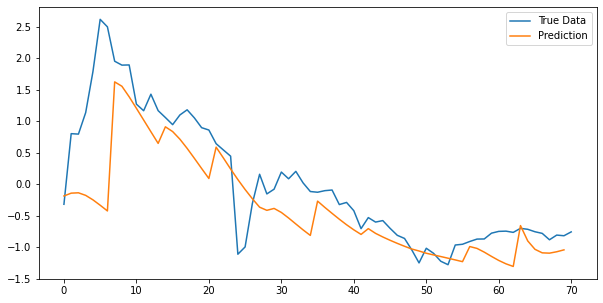

In [93]:
plot_results(np.array(doge_predictions).flatten(), doge_test_y)

In [ ]:
from tensorflow.keras import preprocessing

def create_timeseries_data(df, target_col, sequence_length, batch_size):    
    ts_data = preprocessing.timeseries_dataset_from_array(
    # Select all columns and all rows up to the sequence length
    df.values[:-sequence_length,:],
    # Target data with sequence length offset
    df[target_col].values[sequence_length:],
    sequence_length=sequence_length,
    batch_size=batch_size
    )
    return ts_data

In [ ]:
def create_univariate_timeseries_data(df, sequence_length):
    y = df[sequence_length:]
    data = df.values.reshape(-1, 1)
    n = data.shape[0]
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(sequence_length, 0, -1))]))
    return X.reshape(-1, sequence_length, 1), y.values

In [ ]:
def create_multivariate_timeseries_data(df, sequence_length):
    y = df[target_col][sequence_length:]
    n = df.shape[0]
    X = np.stack([df[i: j] for i, j in enumerate(range(sequence_length, n))], axis=0)
    return X, y.values

In [ ]:
from kats.models.lstm import LSTMModel, LSTMParams

params = LSTMParams(hidden_size=5, time_window=30, num_epochs=35)
m = LSTMModel(btc_ts, params)
m.fit()

In [ ]:
fcst = m.predict(steps=7)
m.plot()
plt.show()